In [1]:
import tensorflow as tf
import numpy as np
from censai.data.kappa_tng import decode_train, decode_shape
from censai.utils import nullwriter, vae_residual_plot as residual_plot, plot_to_image
from censai.definitions import PolynomialSchedule, log_10, DTYPE
from censai.models import VAE
import os, glob, json
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time

VAE_HPARAMS = [
    "pixels",
    "layers",
    "conv_layers",
    "filter_scaling",
    "filters",
    "kernel_size",
    "kernel_reg_amp",
    "bias_reg_amp",
    "activation",
    "dropout_rate",
    "batch_norm",
    "latent_size"
]


In [8]:
def main(args):
    if args.seed is not None:
        tf.random.set_seed(args.seed)
        np.random.seed(args.seed)
    if args.json_override is not None:
        if isinstance(args.json_override, list):
            files = args.json_override
        else:
            files = [args.json_override,]
        for file in files:
            with open(file, "r") as f:
                json_override = json.load(f)
            args_dict = vars(args)
            args_dict.update(json_override)

    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for pixels in dataset.map(decode_shape):
        break
    vars(args).update({"pixels": int(pixels)})
    dataset = dataset.map(decode_train).map(log_10).batch(args.batch_size)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items / args.batch_size)) # dont forget to divide by batch size!
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items / args.batch_size))
    val_dataset = val_dataset.take(math.ceil((1 - args.train_split) * args.total_items / args.batch_size))

    vae = VAE(
        pixels=pixels,
        layers=args.layers,
        conv_layers=args.conv_layers,
        filter_scaling=args.filter_scaling,
        filters=args.filters,
        kernel_size=args.kernel_size,
        kernel_reg_amp=args.kernel_reg_amp,
        bias_reg_amp=args.bias_reg_amp,
        activation=args.activation,
        dropout_rate=args.dropout_rate,
        batch_norm=args.batch_norm,
        latent_size=args.latent_size,
        strides=args.strides
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    beta_schedule = PolynomialSchedule(initial_value=args.beta_init, end_value=args.beta_end_value, power=args.beta_decay_power, decay_steps=args.beta_decay_steps, cyclical=args.beta_cyclical)
    skip_strength_schedule = PolynomialSchedule(initial_value=args.skip_strength_init, end_value=0., power=args.skip_strength_decay_power, decay_steps=args.skip_strength_decay_steps)
    l2_bottleneck_schedule = PolynomialSchedule(initial_value=args.l2_bottleneck_init, end_value=0., power=args.l2_bottleneck_decay_power, decay_steps=args.l2_bottleneck_decay_steps)
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y%m%d%H%M%S")
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "model_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in VAE_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=vae)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
    else:
        save_checkpoint = False

    def train_step(x, step):
        with tf.GradientTape() as tape:
            tape.watch(vae.trainable_weights)
            reconstruction_loss, kl_loss, bottleneck_l2_loss = vae.cost_function_training(x,  skip_strength_schedule(step), l2_bottleneck_schedule(step))
            cost = tf.reduce_sum(reconstruction_loss + beta_schedule(step) * kl_loss + bottleneck_l2_loss) / args.batch_size
        gradients = tape.gradient(cost, vae.trainable_weights)
        if args.clipping:
            gradients = [tf.clip_by_value(grad, -10, 10) for grad in gradients]
        optim.apply_gradients(zip(gradients, vae.trainable_weights))
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        return cost, reconstruction_loss, kl_loss

    def test_step(x,  step):
        reconstruction_loss, kl_loss, bottleneck_l2_loss = vae.cost_function_training(x, skip_strength_schedule(step), l2_bottleneck_schedule(step))
        cost = tf.reduce_sum(reconstruction_loss + beta_schedule(step) * kl_loss + bottleneck_l2_loss) / args.batch_size
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        return cost, reconstruction_loss, kl_loss

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    epoch_reconstruction_loss = tf.metrics.Mean()
    epoch_kl_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    val_reconstruction_loss = tf.metrics.Mean()
    val_kl_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "val_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "train_reconstruction_loss": [],
        "val_reconstruction_loss": [],
        "train_kl_loss": [],
        "val_kl_loss": [],
        "step": [],
        "wall_time": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time * 3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_reconstruction_loss.reset_states()
        epoch_kl_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, x in enumerate(train_dataset):
                start = time.time()
                cost, reconstruction_loss, kl_loss = train_step(x, step=step)
                # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                tf.summary.scalar("beta", beta_schedule(step), step=step)
                tf.summary.scalar("l2 bottleneck", l2_bottleneck_schedule(step), step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_reconstruction_loss.update_state([reconstruction_loss])
                epoch_kl_loss.update_state([kl_loss])
                step += 1
            # last batch we make a summary of residuals
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                y_true = x[res_idx, ...]
                y_pred = vae.call(y_true[None, ...])[0, ...]
                tf.summary.image(f"Residuals {res_idx}", plot_to_image(residual_plot(y_true, y_pred)), step=step)
            # ========== Validation set ===================
            val_loss.reset_states()
            val_reconstruction_loss.reset_states()
            val_kl_loss.reset_states()
            for x in val_dataset:
                cost, reconstruction_loss, kl_loss = test_step(x, step=step)
                val_loss.update_state([cost])
                val_reconstruction_loss.update_state([reconstruction_loss])
                val_kl_loss.update_state([kl_loss])
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                y_true = x[res_idx, ...]
                y_pred = vae.call(y_true[None, ...])[0, ...]
                tf.summary.image(f"Val Residuals {res_idx}", plot_to_image(residual_plot(y_true, y_pred)), step=step)

            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            train_reconstruction_cost = epoch_reconstruction_loss.result().numpy()
            val_reconstruction_cost = val_reconstruction_loss.result().numpy()
            train_kl_cost = epoch_kl_loss.result().numpy()
            val_kl_cost = val_kl_loss.result().numpy()
            tf.summary.scalar("KL", train_kl_cost, step=step)
            tf.summary.scalar("Val KL", val_kl_cost, step=step)
            tf.summary.scalar("Reconstruction loss", train_reconstruction_cost, step=step)
            tf.summary.scalar("Val reconstruction loss", val_reconstruction_cost, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
            tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| lr {optim.lr(step).numpy():.2e} | time/step {time_per_step.result().numpy():.2e} s"
              f"| rec loss {train_reconstruction_cost:.2e} | kl loss {train_kl_cost:.2e}"
             )
        history["train_cost"].append(train_cost)
        history["val_cost"].append(val_cost)
        history["train_reconstruction_loss"].append(train_reconstruction_cost)
        history["val_reconstruction_loss"].append(val_reconstruction_cost)
        history["train_kl_loss"].append(train_kl_cost)
        history["val_kl_loss"].append(val_kl_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["time_per_step"].append(time_per_step.result().numpy())
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return history, vae, train_dataset, val_dataset

In [9]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",        default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--datasets",               required=True, nargs="+",       help="Path to kappa directories, with tfrecords files")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# Model params
parser.add_argument("--layers",                 default=4,              type=int,       help="Number of layer in encoder/decoder")
parser.add_argument("--conv_layers",            default=2,              type=int,       help="Number of convolution layers in a block")
parser.add_argument("--filter_scaling",         default=2,              type=float,     help="Filter scaling after each layers")
parser.add_argument("--filters",                default=8,              type=int,       help="Number of filters in the first layer")
parser.add_argument("--kernel_size",            default=3,              type=int)
parser.add_argument("--kernel_reg_amp",         default=1e-4,           type=float,     help="L2 kernel regularization amplitude")
parser.add_argument("--bias_reg_amp",           default=1e-4,           type=float,     help="L2 bias regularizer amplitude")
parser.add_argument("--activation",             default="relu",                         help="Name of activation function, on of ['relu', 'leaky_relu', 'bipolar_relu', 'bipolar_leaky_relu', 'bipolar_elu', 'gelu', etc.]")
parser.add_argument("--dropout_rate",           default=None,           type=float,     help="2D spatial dropout rate (drop entire feature map to help them become independent)")
parser.add_argument("--batch_norm",             default=0,              type=int,       help="0: False, do no use batch norm. 1: True, use batch norm beforce activation")
parser.add_argument("--latent_size",            default=16,             type=int,       help="Twice the size of the latent code vector z")
parser.add_argument("--strides",                default=2,              type=int,)

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given batch.")

# Optimization params
parser.add_argument("-e", "--epochs",                   default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",                      default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",          default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",                     default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",                    default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--beta_init",                      default=0.,     type=float,     help="Initial value of the beta schedule")
parser.add_argument("--beta_end_value",                 default=1.,     type=float,     help="End value of the beta schedule")
parser.add_argument("--beta_decay_power",               default=1.,     type=float,     help="Power of the Polynomial schedule")
parser.add_argument("--beta_decay_steps",               default=1000,   type=int,       help="Number of steps until end of schedule is reached")
parser.add_argument("--beta_cyclical",                  default=0,      type=int,       help="Make beta schedule cyclical if 1. 0: Monotone schedule.")
parser.add_argument("--skip_strength_init",             default=1.,     type=float,     help="Initial value of the skip_strength schedule")
parser.add_argument("--skip_strength_end_value",        default=0.,     type=float,     help="End value of the skip_strength schedule")
parser.add_argument("--skip_strength_decay_power",      default=0.5,    type=float,     help="Power of the Polynomial schedule")
parser.add_argument("--skip_strength_decay_steps",      default=1000,   type=int,       help="Number of steps until end of schedule is reached")
parser.add_argument("--l2_bottleneck_init",             default=1.,     type=float,     help="Initial value of the l2_bottleneck schedule")
parser.add_argument("--l2_bottleneck_end_value",        default=0.,     type=float,     help="End value of the l2_bottleneck schedule")
parser.add_argument("--l2_bottleneck_decay_power",      default=0.5,    type=float,     help="Power of the Polynomial schedule")
parser.add_argument("--l2_bottleneck_decay_steps",      default=1000,   type=int,       help="Number of steps until end of schedule is reached")
parser.add_argument("--staircase",                      action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",                       action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",                       default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",                      default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",                    action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",                       default=np.inf, type=float,     help="Time allowed for the training, in hours.")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="KappaVAE",            help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=5,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,   nargs="+",      help="A json filepath that will override every command line parameters. Useful for reproducibility")



_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [ ]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('CENSAI_PATH')}/data/hkappa128_TNG100_trainset/ "\
  f"--datasets {os.getenv('CENSAI_PATH')}/data/hkappa128_TNG100_trainset_fr/ "\
  f"--compression_type=GZIP "\
  f"--epochs=20 "\
  f"--batch_size 32 "\
  f"--train_split=0.95 "\
  f"--total_items 50000 "\
  f"--optimizer Adam "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=10000 "\
  f"--beta_init=0.1 "\
  f"--beta_end_value=0.3 "\
  f"--beta_decay_power=0.5 "\
  f"--beta_decay_steps=10000 "\
  f"--beta_cyclical=0 "\
  f"--skip_strength_init=0 "\
  f"--skip_strength_end_value=0. "\
  f"--skip_strength_decay_power=0.5 "\
  f"--skip_strength_decay_steps=2000 "\
  f"--l2_bottleneck_init=1e-2 "\
  f"--l2_bottleneck_end_value=0 "\
  f"--l2_bottleneck_decay_power=0.5 "\
  f"--l2_bottleneck_decay_steps=20000 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=3 "\
  f"--tolerance=0.01 "\
  f"--block_length=1 "\
  f"--layers=4 "\
  f"--conv_layers=1 "\
  f"--filter_scaling=2 "\
  f"--filters=16 "\
  f"--kernel_size=3 "\
  f"--kernel_reg_amp=0 "\
  f"--bias_reg_amp=0 "\
  f"--activation=leaky_relu "\
  f"--batch_norm=1 "\
  f"--latent_size=84 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('CENSAI_PATH')}/logsVAE_hkappa "\
  f"--logname_prefixe=VAE1_hkappa_HPARAMS "\
  f"--model_dir={os.getenv('CENSAI_PATH')}/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=10 "\
  f"--n_residuals=3 "\
  f"--track_train "\
  f"--max_time=1".split(" ")
)

cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
if args.seed is not None:
    tf.random.set_seed(args.seed)
    np.random.seed(args.seed)

history, vae, train_dataset, val_dataset = main(args)

epoch 0 | train loss 4.782e+02 | val loss 1.345e+02 | lr 1.00e-04 | time/step 4.54e-02 s| rec loss 4.43e+02 | kl loss 3.38e+02
Saved checkpoint for step 2: /home/aadam/scratch/Censai//models/VAE1_hkappa_HPARAMS_211016152853/ckpt-1
epoch 1 | train loss 1.089e+02 | val loss 9.356e+01 | lr 1.00e-04 | time/step 4.40e-02 s| rec loss 8.86e+01 | kl loss 1.65e+02
epoch 2 | train loss 8.469e+01 | val loss 8.171e+01 | lr 1.00e-04 | time/step 4.47e-02 s| rec loss 6.86e+01 | kl loss 1.14e+02
epoch 3 | train loss 7.629e+01 | val loss 6.865e+01 | lr 1.00e-04 | time/step 4.47e-02 s| rec loss 6.10e+01 | kl loss 9.46e+01
epoch 4 | train loss 7.347e+01 | val loss 6.687e+01 | lr 1.00e-04 | time/step 4.47e-02 s| rec loss 5.78e+01 | kl loss 8.48e+01
epoch 5 | train loss 7.049e+01 | val loss 7.060e+01 | lr 1.00e-04 | time/step 4.44e-02 s| rec loss 5.39e+01 | kl loss 7.72e+01
Saved checkpoint for step 7: /home/aadam/scratch/Censai//models/VAE1_hkappa_HPARAMS_211016152853/ckpt-2
epoch 6 | train loss 7.105e+01

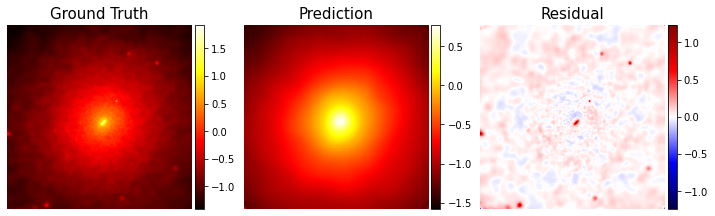

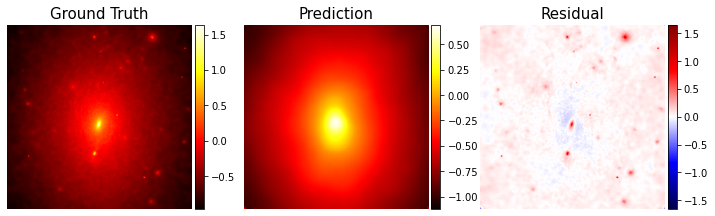

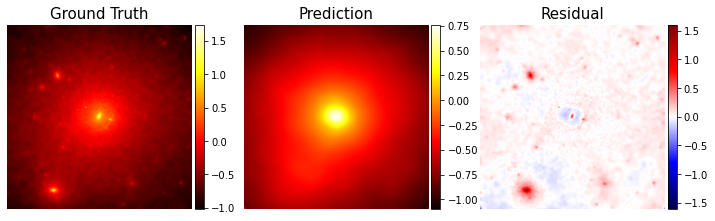

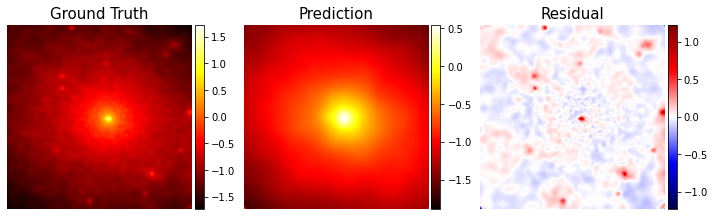

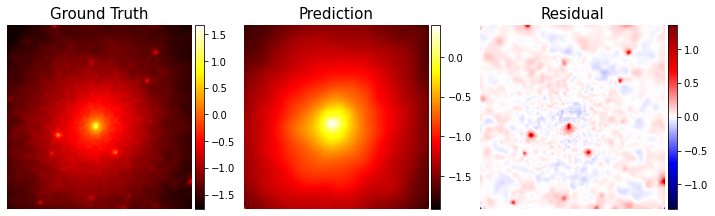

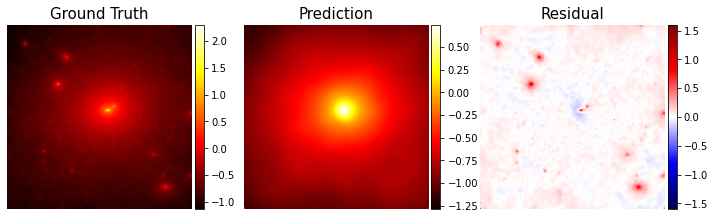

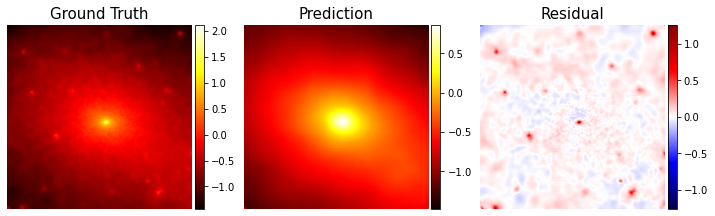

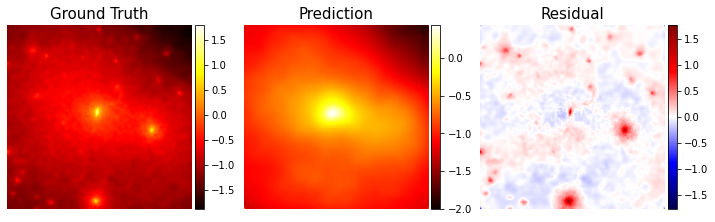

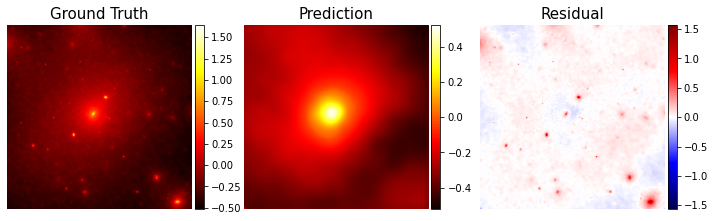

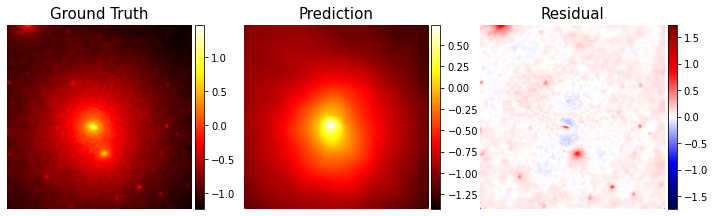

In [5]:
b = 1
for batch, x in enumerate(train_dataset):
    if batch == b:
        for res_idx in range(args.batch_size):
            kappa_true = x[res_idx, ...]
            kappa_pred = vae(kappa_true[None, ...])[0, ...]
            fig = residual_plot(kappa_true, kappa_pred)
        break

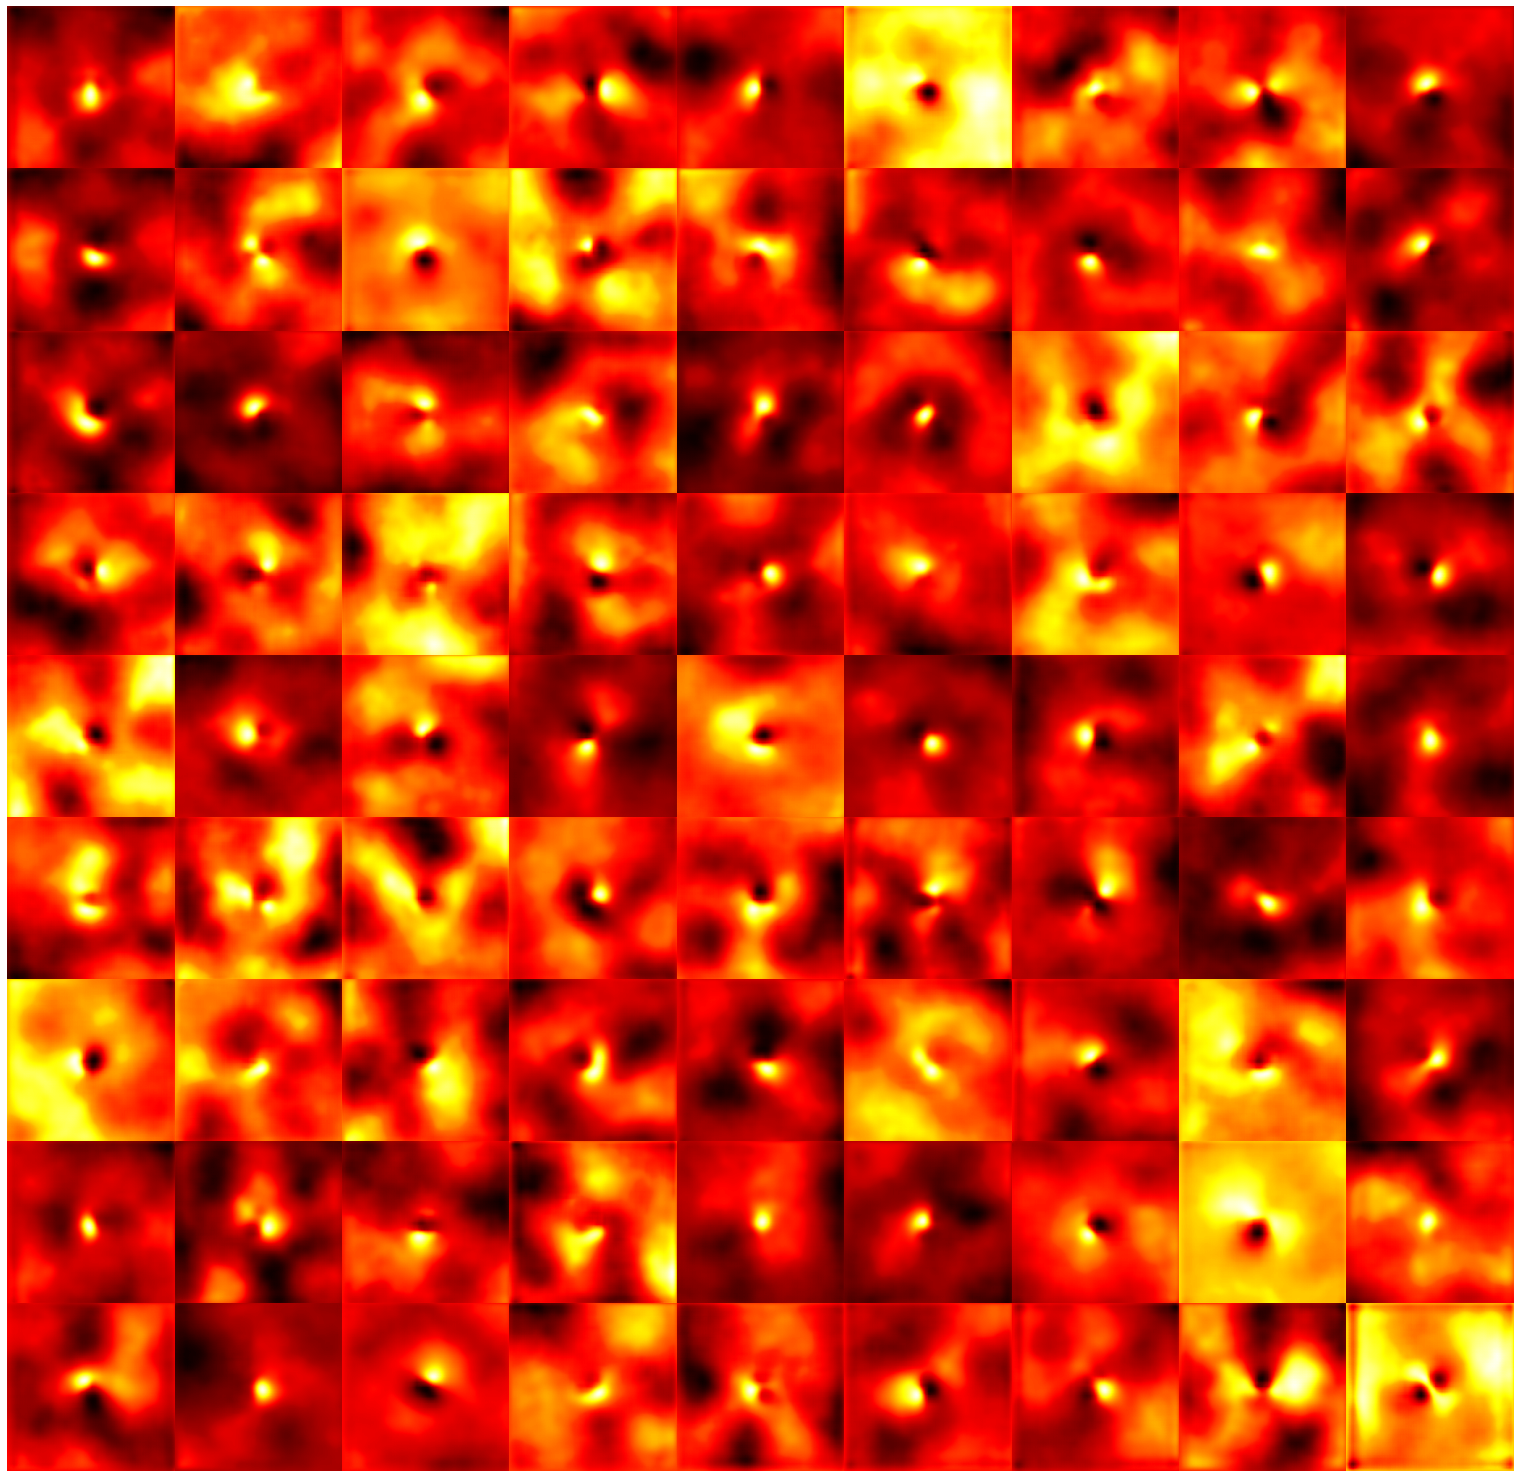

In [6]:
z = tf.random.normal([81, vae.latent_size], dtype=tf.float32)
y = vae.decode(z)
fig, axs = plt.subplots(9, 9, figsize=(27, 27))
for i in range(9):
    for j in range(9):
        k = 9 * j + i 
        axs[i, j].imshow(y[k, ..., 0], cmap="hot", origin="lower")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=-0.05)